/home/liusong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  from ipykernel import kernelapp as app
/usr/local/python3/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


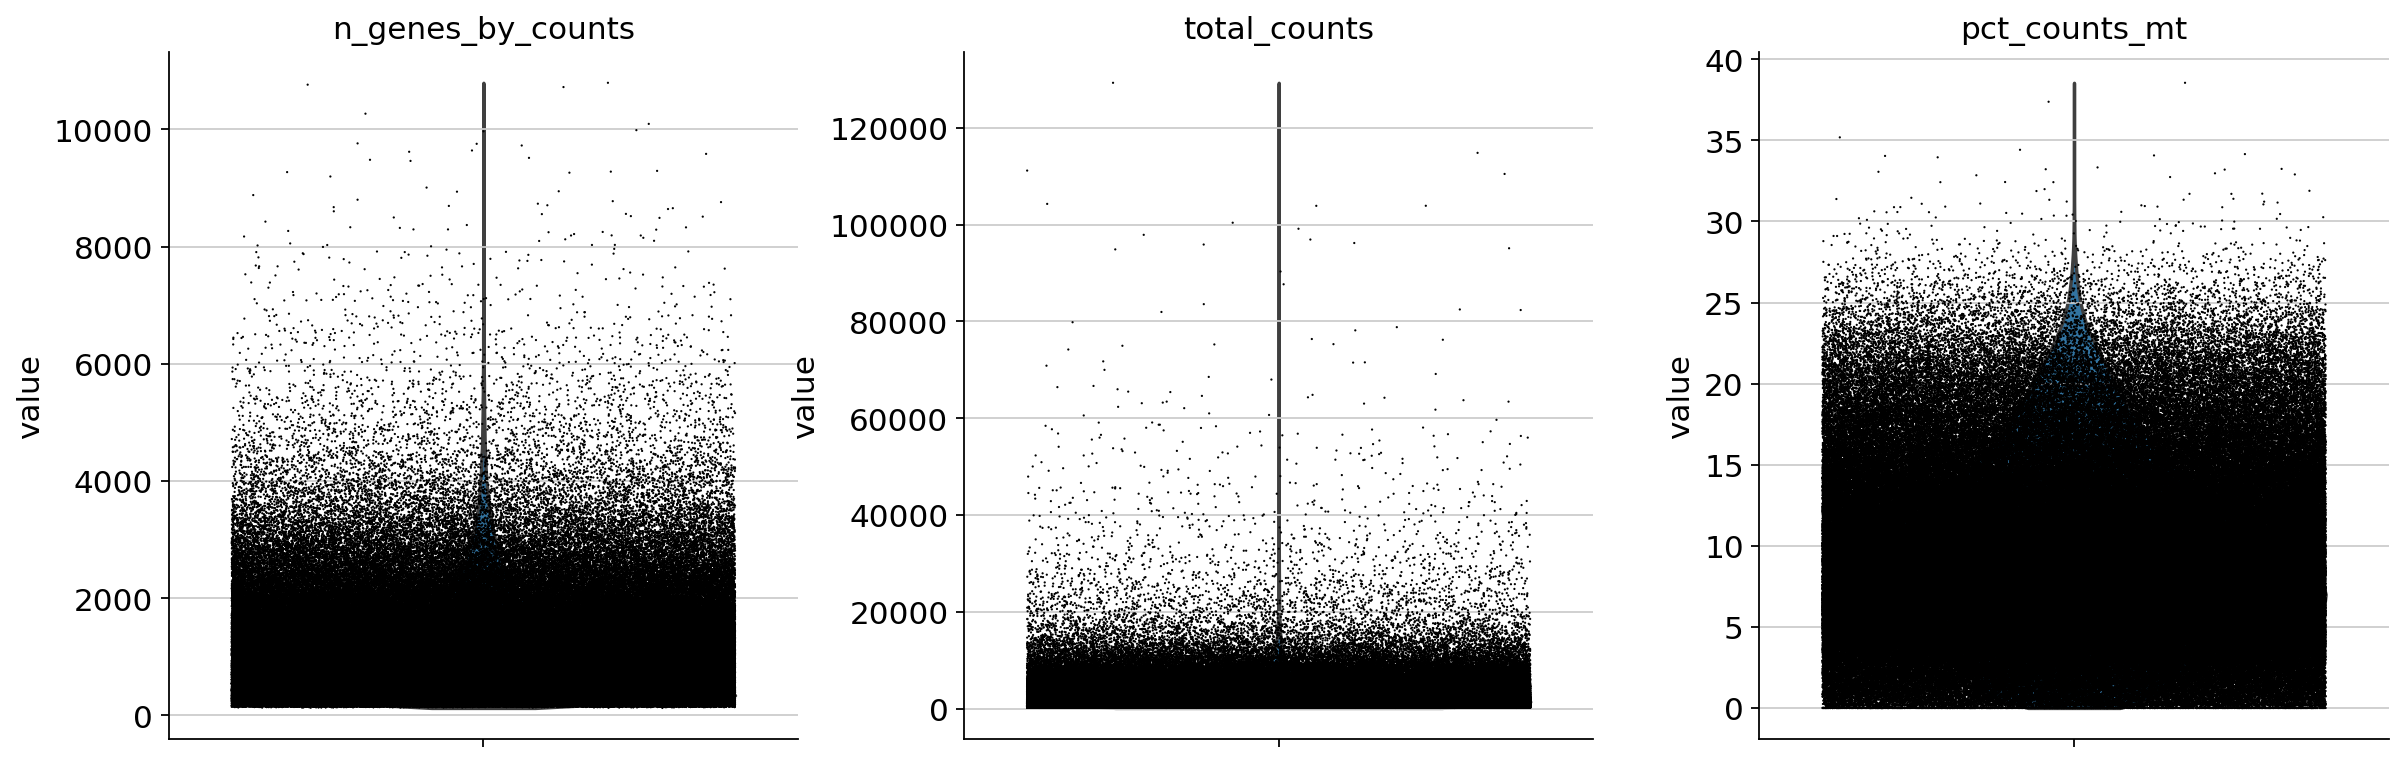

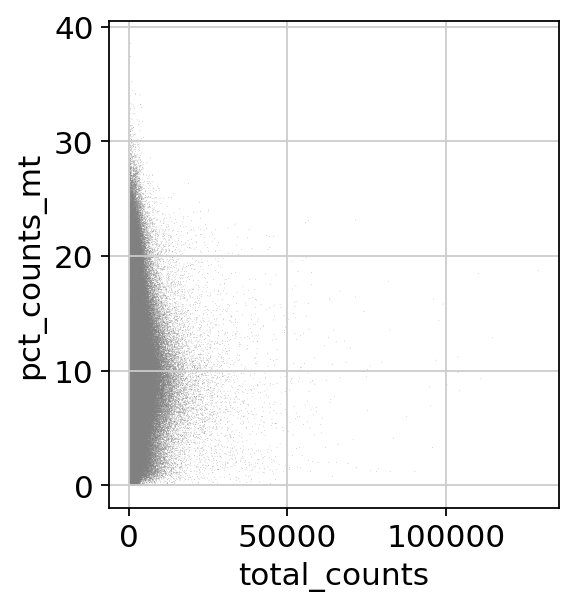

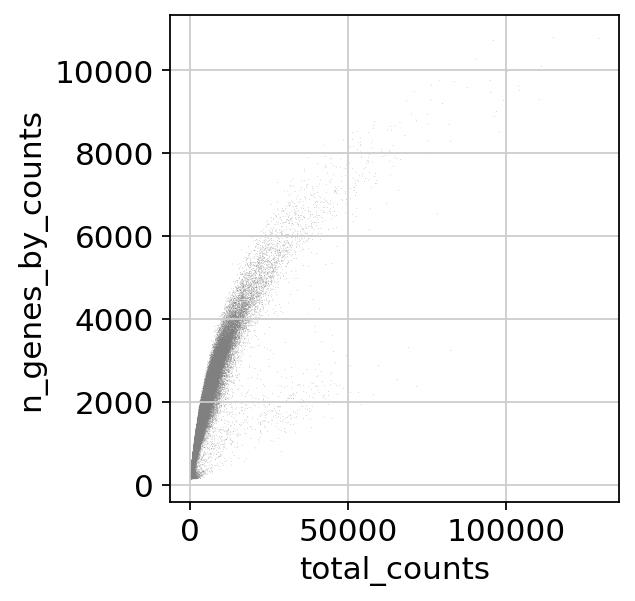

In [31]:
import numpy as np
import pandas as pd
import scanpy as sc
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import scanpy.external as sce
import bbknn
sc.set_figure_params(dpi_save=300)

NGdata=sc.read_h5ad("NG_alldata2024.h5ad")
ribosomes=NGdata.var_names.str.match("^RP[LS]")
NGdata=NGdata[:,~ribosomes] 

NGdata.var['mt']=NGdata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(NGdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(NGdata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)
sc.pl.scatter(NGdata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(NGdata, x='total_counts', y='n_genes_by_counts')
sc.pp.normalize_total(NGdata, target_sum=1e4)
sc.pp.log1p(NGdata)
NGdata.__dict__['_raw'].__dict__["_var"]=NGdata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
NGdata.obs['sampleID']=NGdata.obs_names.str.lstrip('ATCG-')
NGdata.write("NG_alldata_normalized.h5ad")

/home/liusong/.local/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


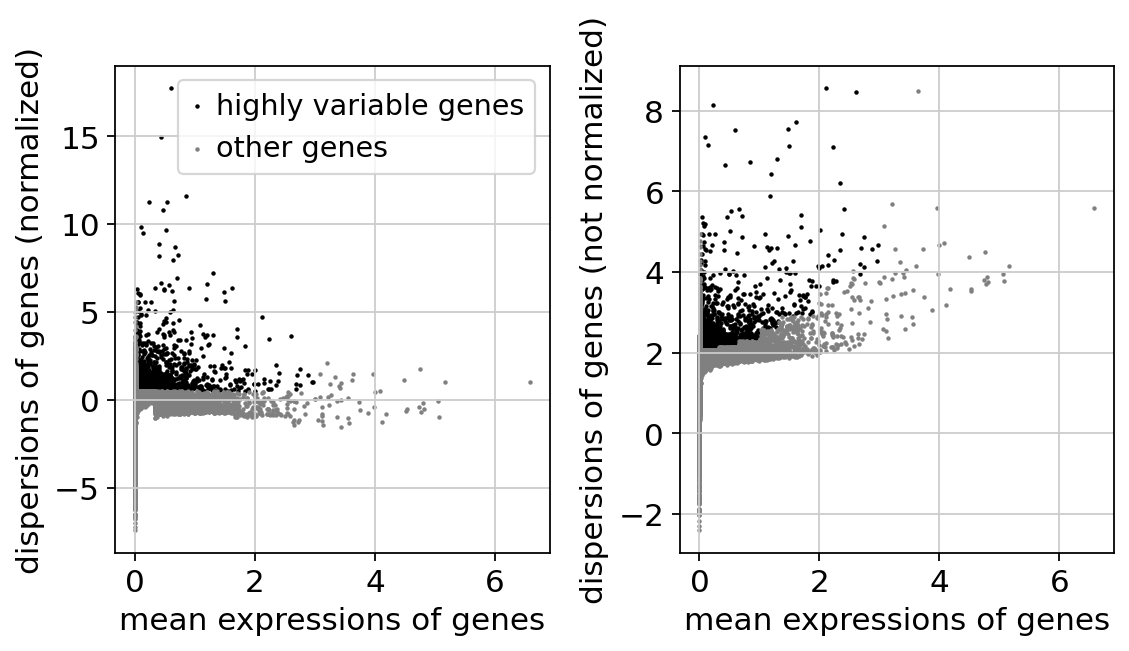

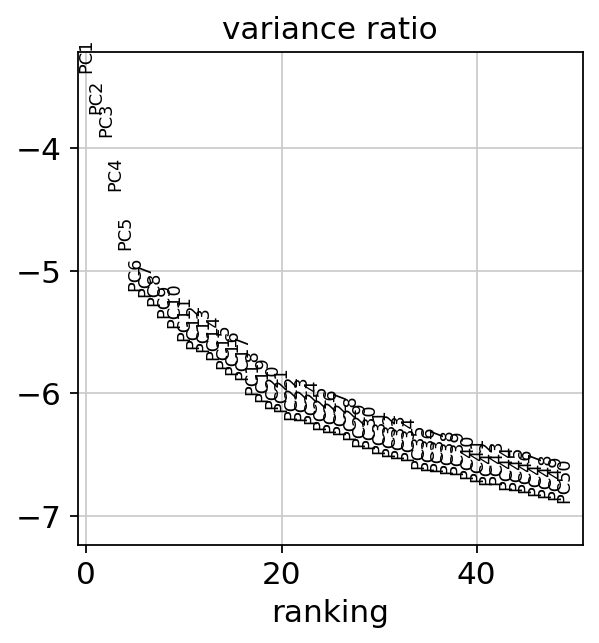

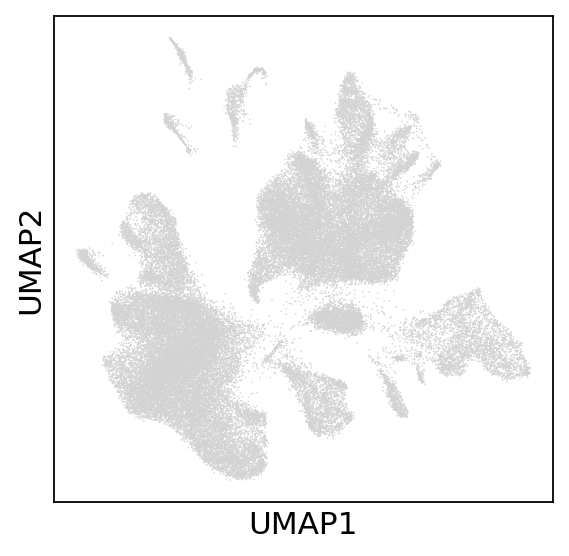

In [32]:
NGOMA=NGdata[NGdata.obs["Major.Class"]=="Endometrioma",]
sc.pp.highly_variable_genes(NGOMA, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(NGOMA)
NGOMA.raw = NGOMA

NGOMA = NGOMA[:, NGOMA.var.highly_variable]
sc.pp.regress_out(NGOMA, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(NGOMA, max_value=10)
sc.tl.pca(NGOMA, svd_solver='arpack')
sc.pl.pca_variance_ratio(NGOMA, log=True,n_pcs=50)

bbknn.bbknn(NGOMA,batch_key='sampleID')
sc.tl.umap(NGOMA)
sc.pl.umap(NGOMA)
sc.tl.leiden(NGOMA)

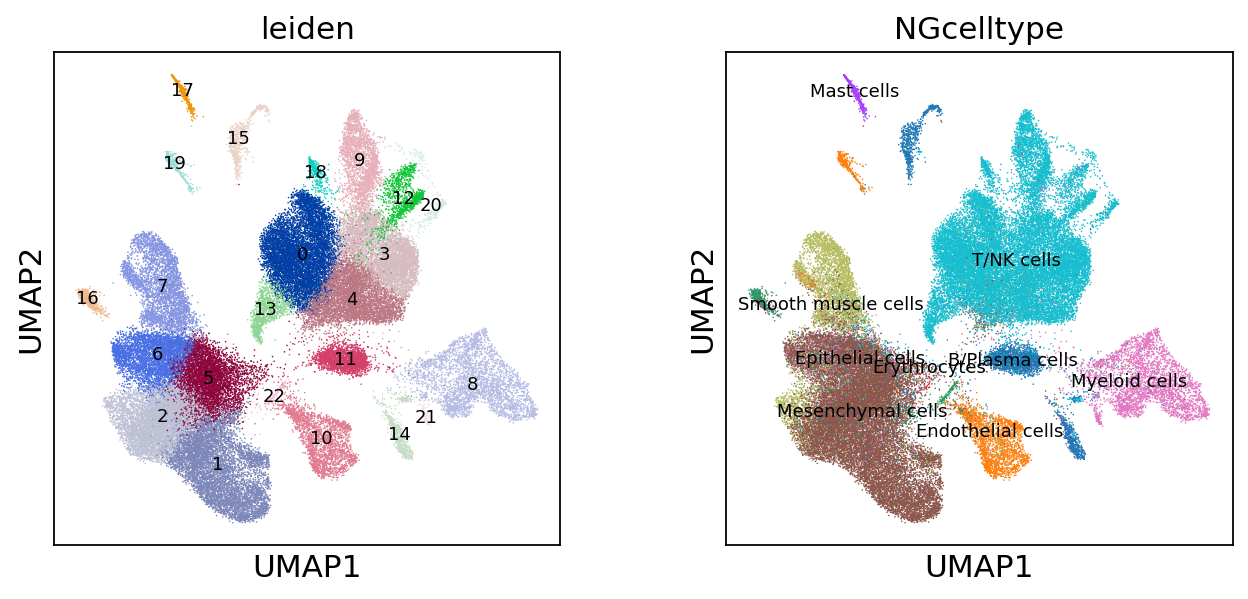

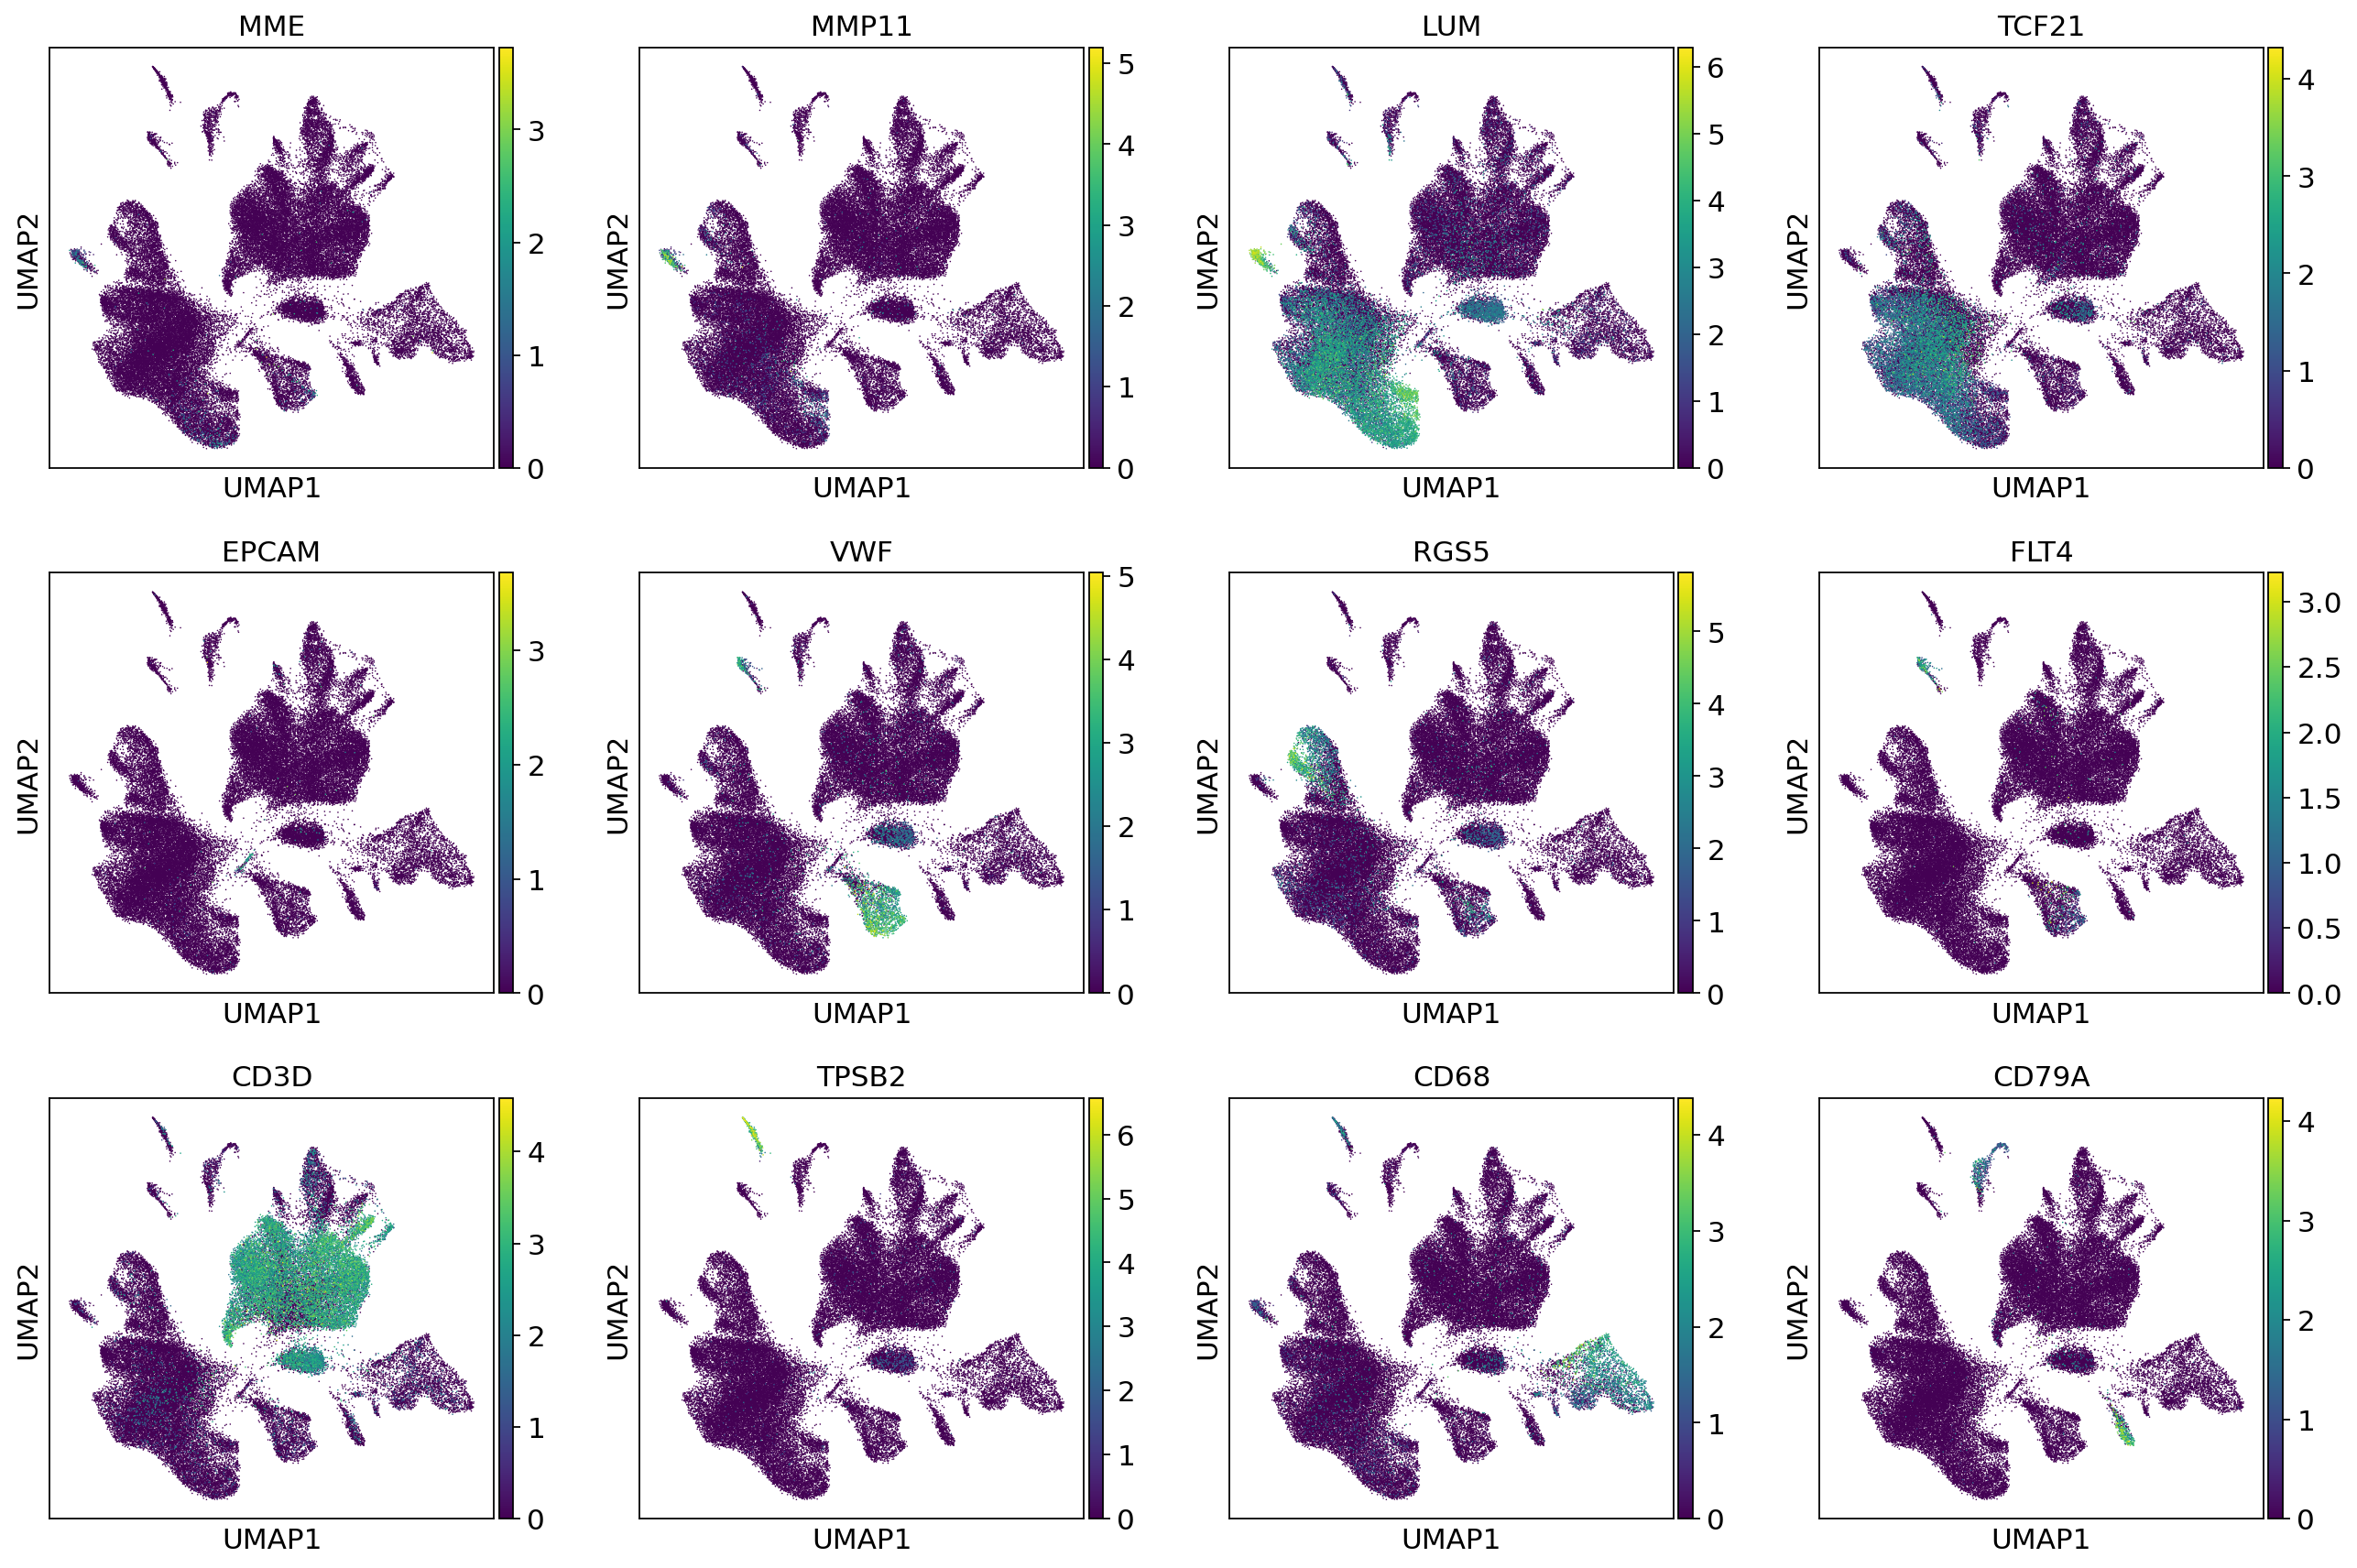

/home/liusong/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


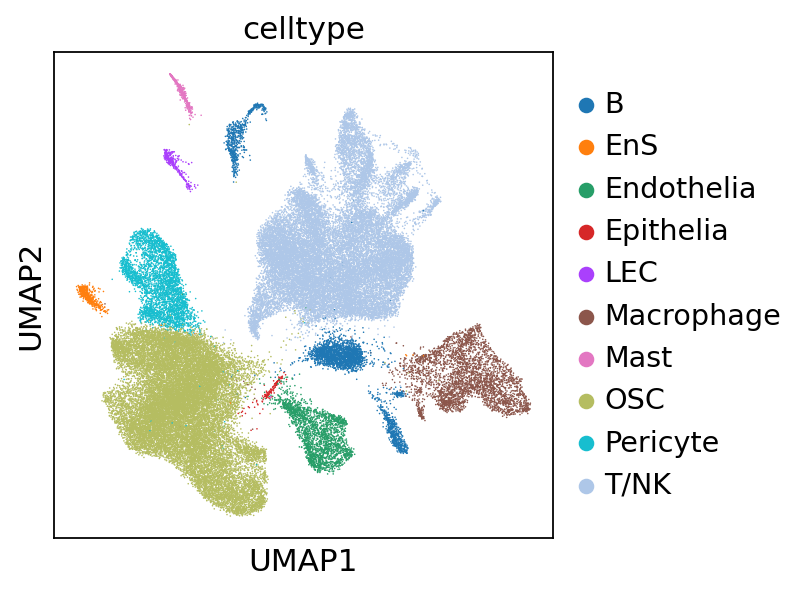

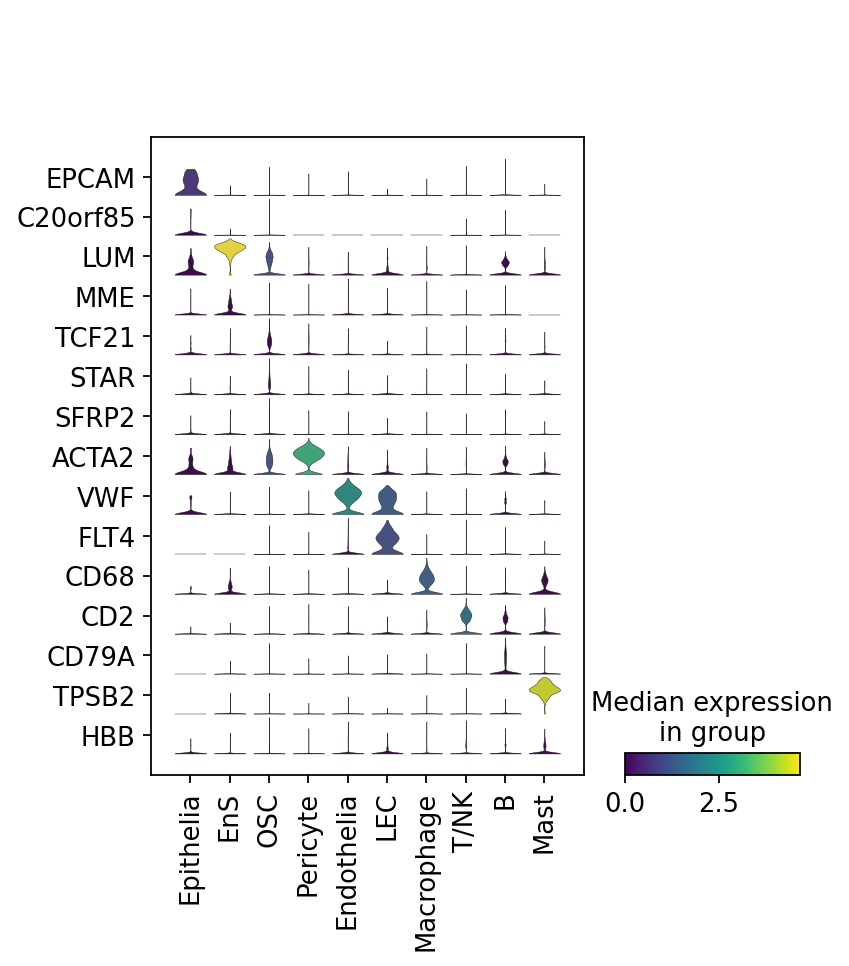

In [33]:
sc.pl.umap(NGOMA,color=['leiden',"NGcelltype"],legend_loc="on data",legend_fontsize='xx-small',legend_fontweight='medium')
sc.pl.umap(NGOMA,color=['MME','MMP11','LUM','TCF21','EPCAM','VWF','RGS5','FLT4','CD3D','TPSB2','CD68','CD79A'])
OMAnew_cluster_names=['T/NK0', 'OSC1','OSC2','T/NK3','T/NK4','OSC5','OSC6','Pericyte7','Macrophage8','T/NK9','Endothelia10','B11','T/NK12','T/NK13','B14','B15','EnS16','Mast17','T/NK18','LEC19','T/NK20','Macrophage21','Epithelia22']
NGOMA.obs['myname']=NGOMA.obs['leiden']
NGOMA.rename_categories('myname', OMAnew_cluster_names)
NGOMA.obs['newcelltype']=NGOMA.obs.myname.str.strip('0123456789')
sc.pl.umap(NGOMA, color=['newcelltype'],save="NGOMA_newcelltype.pdf")
sc.pl.stacked_violin(NGOMA,['EPCAM','C20orf85','LUM','MME','TCF21','STAR','SFRP2','ACTA2','VWF','FLT4','CD68','CD2','CD79A','TPSB2','HBB'],groupby="newcelltype",categories_order=['Epithelia','EnS','OSC','Pericyte','Endothelia','LEC','Macrophage','T/NK','B','Mast'],cmap=None,save="NGOMA_cellmarkes_stacked_violiln.pdf",swap_axes=True)
NGOMA.write("NG_OMA_umap_leiden_BBKNN.h5ad")